### Oppgave 5 Visualisering
#### Importerer nødvendige biblioteker

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

#### Valg av flyplass, enten ENOL eller ENBO

In [2]:
#airport = "ENBO"
airport = "ENOL"

In [3]:
file_path = f'../data/csv/{airport}_wind_data.csv'
df_airport = pd.read_csv(file_path)

#### 2D Scatter-plot av vindretning og vindhastighet

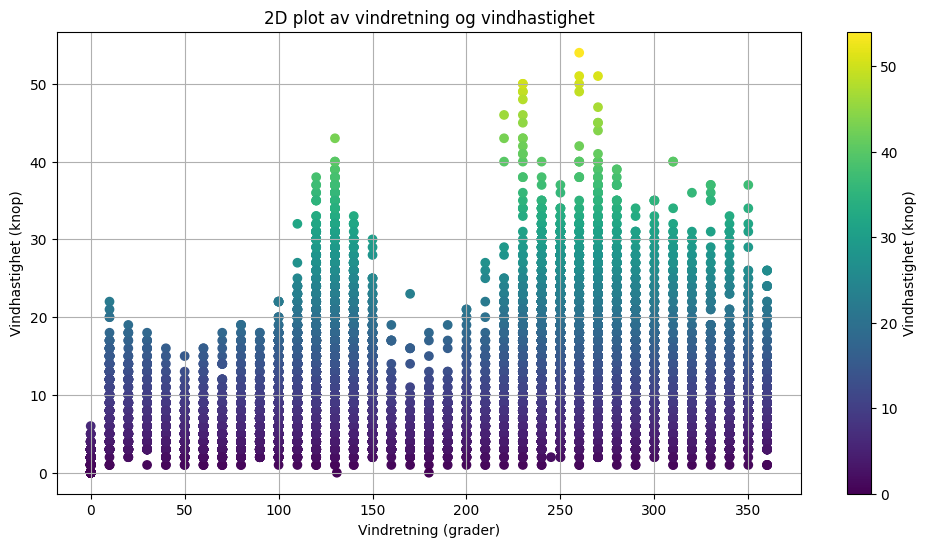

In [4]:
fig = plt.figure(figsize=(12, 6))
plt.scatter(df_airport['Wind_direction'], df_airport['Wind_speed'], c=df_airport['Wind_speed'], cmap='viridis', marker='o')
plt.title('2D plot av vindretning og vindhastighet')
plt.xlabel('Vindretning (grader)')
plt.ylabel('Vindhastighet (knop)')
plt.colorbar(label='Vindhastighet (knop)') # Legger til fargeskala
plt.grid(True)
plt.show()


#### Vindrose for aktuell flyplass

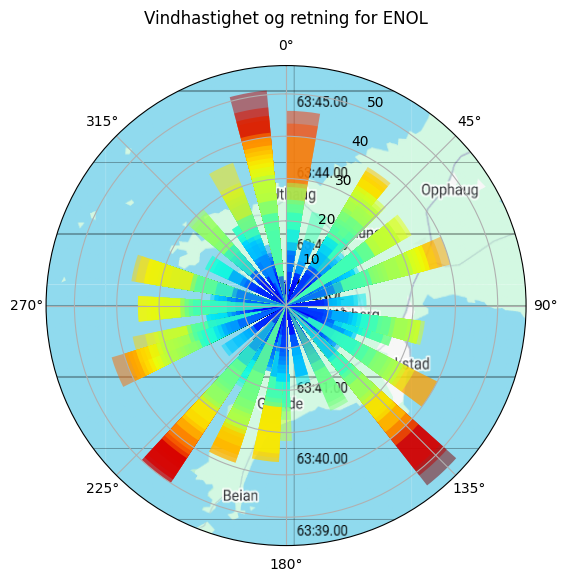

In [5]:
# Konverter vindretningen fra grader til radianer (for polarplot)
theta = df_airport['Wind_direction']
radii = df_airport['Wind_speed']

# Sett en konstant bredde for stolpene, f.eks. 10 grader (omregnet til radianer)
width = np.deg2rad(10)

# Lag figur og polar akse
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)

ax.set_theta_zero_location("N") # Sett nullpunktet til nord
ax.set_theta_direction(-1)

img = plt.imread(f"../resources/images/{airport}_kart.png")
ax.imshow(img, extent=[0, 1, 0, 1], transform=ax.transAxes, zorder=0)

# Lag stolpediagrammet
bars = ax.bar(theta, radii, width=width, bottom=0.0)

# Tilpass farger etter vindhastigheten
for r, bar in zip(radii, bars):
    bar.set_facecolor(cm.jet(r / np.max(radii)))
    bar.set_alpha(0.5)

ax.set_title(f"Vindhastighet og retning for {airport}", pad=30)

plt.show()

#### Beregner gjennomsnittlig vindhastighet og retning på aktuell flyplass

In [6]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Antall dager per måned i 2024 (skuddår)
days_per_month = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

# Beregn gjennomsnitt for hver måned
avg_wind_speed = []
avg_wind_direction = []

start_idx = 0
for days in days_per_month:
    end_idx = start_idx + 48 * days  # 48 målinger per dag (hver halvtime)
    avg_wind_speed.append(df_airport['Wind_speed'][start_idx:end_idx].mean())
    avg_wind_direction.append(df_airport['Wind_direction'][start_idx:end_idx].mean())
    start_idx = end_idx  # oppdater start for neste måned


#### Visualisering av gjennomsnittlig vind-retning og hastighet per måned

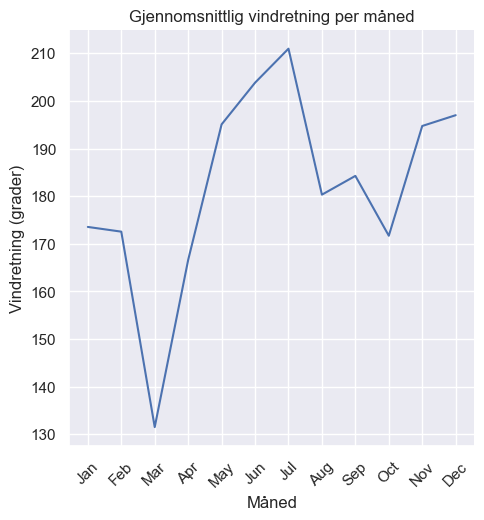

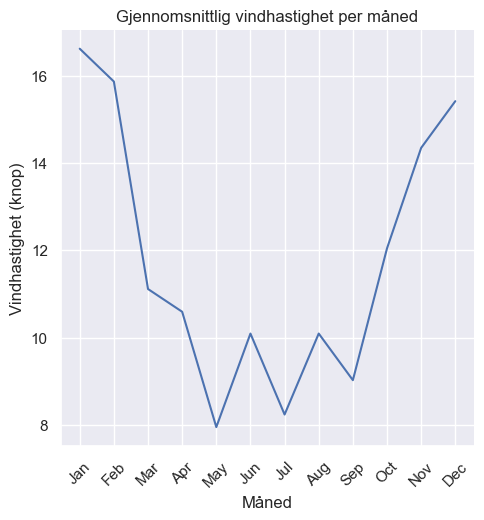

In [7]:
sns.set_theme(style="darkgrid")
sns.relplot(x = months, y = avg_wind_direction, kind="line")
plt.xticks(rotation=45)
plt.xlabel("Måned")
plt.ylabel("Vindretning (grader)")
plt.title("Gjennomsnittlig vindretning per måned")
plt.show()

# Plotting gjennomsnittlig vindhastighet per måned
sns.relplot(x = months, y = avg_wind_speed, kind="line")
plt.xticks(rotation=45)
plt.xlabel("Måned")
plt.ylabel("Vindhastighet (knop)")
plt.title("Gjennomsnittlig vindhastighet per måned")
plt.show()


Beregner standardavvik og drøfter resultater

In [8]:
# Er standardaviken for vindhastighet og vindkast-hastighet lik?
std_wind_speed = df_airport['Wind_speed'].std()
std_gust_speed = df_airport['Gust_speed'].std()
std_wind_direction = df_airport['Wind_direction'].std()


print(f"Standardavvik vindhastighet: {std_wind_speed.round(2)} for {airport}")
print(f"Standardavvik vindkast-hastighet: {std_gust_speed.round(2)} for {airport}")
print(f"\nStandardavvik vindretning: {std_wind_direction.round(2)} for {airport}")
print(f"\nVi ser at standardavviktet ikke er alt for høyt når deg gjelder vindhastighet og vindkast-hastighet. \nMen når vi ser på vindretning er det veldig stor variasjon {std_wind_direction.round(2)}. Dette gir mening med tanke på valg av data.")
# Er standaraviken større for vindhastighet når det er lavt trykk?



Standardavvik vindhastighet: 7.12 for ENOL
Standardavvik vindkast-hastighet: 7.38 for ENOL

Standardavvik vindretning: 93.31 for ENOL

Vi ser at standardavviktet ikke er alt for høyt når deg gjelder vindhastighet og vindkast-hastighet. 
Men når vi ser på vindretning er det veldig stor variasjon 93.31. Dette gir mening med tanke på valg av data.


#### Vindhastighet sammenlignet med trykk (QNH)

Korrelasjon mellom vindhastighet og trykk (QNH) er -0.26


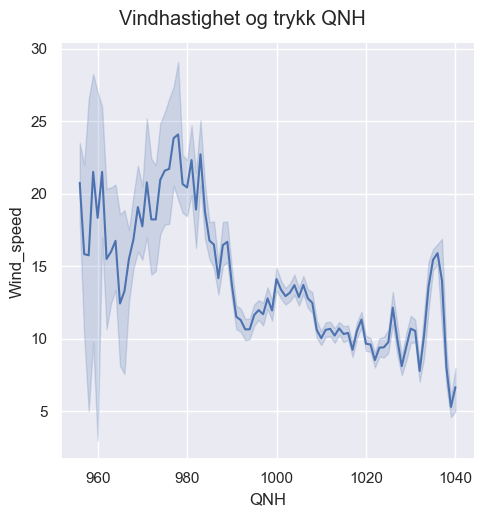

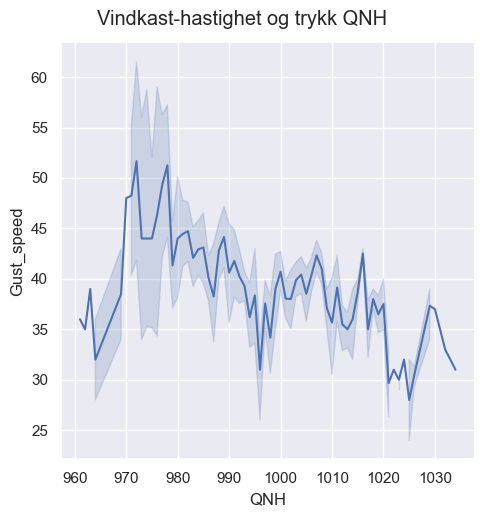

In [9]:
correlation = df_airport['Wind_speed'].corr(df_airport['QNH'])
print(f"Korrelasjon mellom vindhastighet og trykk (QNH) er {correlation.round(2)}")

# plott 1
plot1 = sns.relplot(x="QNH", y="Wind_speed", kind="line", data=df_airport)
_ = plot1.fig.suptitle("Vindhastighet og trykk QNH", y=1.03)

# plott 2
plot2 = sns.relplot(x="QNH", y="Gust_speed", kind="line", data=df_airport)
_ = plot2.fig.suptitle("Vindkast-hastighet og trykk QNH", y=1.03)

Vi ser en sammenheng mellom vindhastighet og trykk QNH.
Når trykket er lavt er det høyere vindhastighet enn når trykket er høyt.
Dette gir mening med tanke på at lavtrykk gir mer vind og høytrykk gir mindre vind.
Samme gjelder for Vindkast-hastighet, vinden er mer uregelmessig når trykket er lavt.

Vi får også dette bekreftet ved å se på korrelasjonen, nedenfor ser vi nærmere på det i Kryss-korrelasjonsdiagrammet.

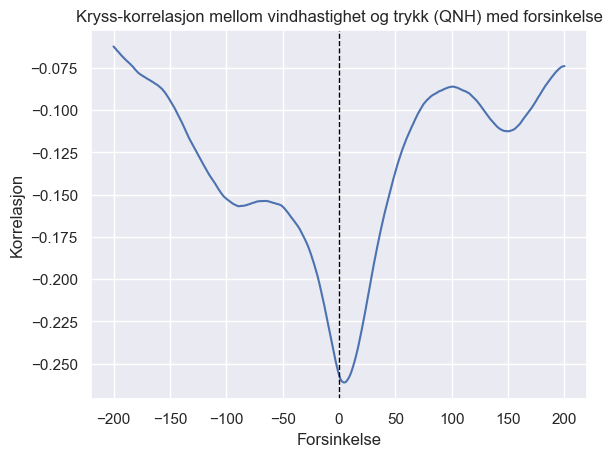

In [10]:
max_lag = 200
lags = np.arange(-max_lag, max_lag + 1)
cross_corr = [df_airport['Wind_speed'].corr(df_airport['QNH'].shift(lag)) for lag in lags]

plt.plot(lags, cross_corr)
plt.title('Kryss-korrelasjon mellom vindhastighet og trykk (QNH) med forsinkelse')
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Forsinkelse')
plt.ylabel('Korrelasjon')
plt.grid(True)
plt.show()


Vi ser her at når QNH er lav er det en 25% korrelasjon for at vindhastigheten er høy, og motsatt.
Her har vi også lagt inn forsinkelse, og vi ser at jo mer forsinkelse på en av verdiene desto mindre korrelasjon er det.

#### Kryss-korrelasjon mellom vindkast-hastighet og trykk (QNH) med forsinkelse

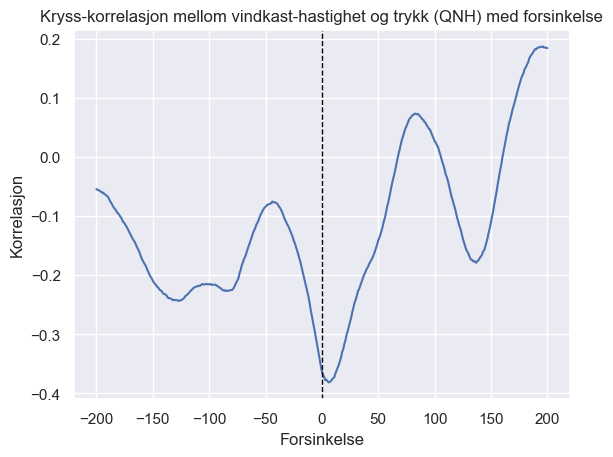

In [18]:
max_lag = 200
lags = np.arange(-max_lag, max_lag + 1)
cross_corr = [df_airport['Gust_speed'].corr(df_airport['QNH'].shift(lag)) for lag in lags]

plt.plot(lags, cross_corr)
plt.title('Kryss-korrelasjon mellom vindkast-hastighet og trykk (QNH) med forsinkelse')
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Forsinkelse')
plt.ylabel('Korrelasjon')
plt.grid(True)
plt.show()

#### Kryss-korrelasjon mellom vindhastighet og vindkast-hastighet med forsinkelse

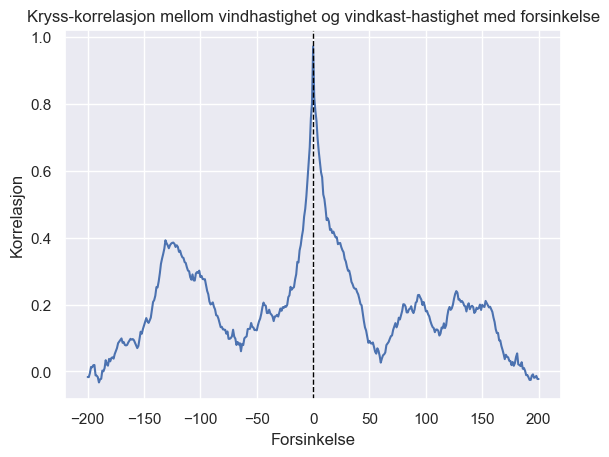

In [12]:
max_lag = 200
lags = np.arange(-max_lag, max_lag + 1)
cross_corr = [df_airport['Wind_speed'].corr(df_airport['Gust_speed'].shift(lag)) for lag in lags]

plt.plot(lags, cross_corr)
plt.title('Kryss-korrelasjon mellom vindhastighet og vindkast-hastighet med forsinkelse')
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Forsinkelse')
plt.ylabel('Korrelasjon')
plt.grid(True)
plt.show()

Her ser vi en enorm korrelasjon, når vindhastighet er høy er vindkast-hastighet alltid høy, altså 100% korrelasjon med ingen forsinkelse.

#### Dynamisk Histogram (KDE analyse) med glattingskostnat

In [13]:
#henter fil fra src mappa.
sys.path.insert(0, '../src/')
from avg_widget import avg_widget

# Interaktiv widget
widgets.interact(
    avg_widget, 
    ses=widgets.FloatSlider(min=0.1, max=5, step=0.25, value=2.5, description='Glatting (ses)')
)

interactive(children=(FloatSlider(value=2.5, description='Glatting (ses)', max=5.0, min=0.1, step=0.25), Outpu…

<function avg_widget.avg_widget(ses=2.5)>

Arealt under kurven til et histogram er alltid 1, da dette representerer hele fordelingen av data.

Simple exponential smoothing er forkortet som ses.
